## Project Installation

This project relies on the following major dependencies:

- [**Python**](https://www.python.org/downloads/): The primary programming language used. We're using the latest Python3
- [**Jupyter Notebook**](https://jupyter.org/install): Handles the .ipynb format file execution.
- [**VSCode**](https://code.visualstudio.com/): Code editor and simple notebook environment.
- **Libraries**: 
  - `opencv-python`: For image processing and computer vision tasks.
  - `scikit-learn`: For machine learning algorithms and data preprocessing.
  - `xgboost`: An efficient implementation of gradient boosting framework.
  - `numpy`: Essential for numerical operations.
  - `matplotlib`: For plotting and visualization of data.
  - `onnxconverter-common`: Common utilities for ONNX model conversion.
  - `onnxmltools`: Tools for converting machine learning models to ONNX format.
  - `skl2onnx`: Specifically for converting scikit-learn models to ONNX format.
  - `google.colab`: Google Colaboratory ONLY - Python notebook format.

Easy Jupyter Notebook installation (with Python3 already installed):
- Open this file in [VSCode](https://code.visualstudio.com/) and use extensions (VSCode will prompt you) to configure and run the python and jupyter env.

### Install Dependencies:

#### In your command prompt with Python 3 installed, type:
`pip install -r requirements.txt`

## Data Download and Extraction:

### Download the dataset and unzip it (linux example calls)
`wget https://storage.googleapis.com/fishazam-sample-dataset/fillet_dataset_small.zip`

`unzip fillet_dataset_small.zip -d ./content`

# Run the notebook:

### Import Libraries

In [43]:
# Import Path from pathlib for file path operations  
from pathlib import Path  
# Import OpenCV for image processing 
import cv2
# Import Pipeline from sklearn for creating a ML pipeline  
from sklearn.pipeline import Pipeline  
# Import StandardScaler for feature scaling  
from sklearn.preprocessing import StandardScaler  
# Import XGBClassifier for the classification model  
from xgboost import XGBClassifier  
# Import numpy for numerical operations  
import numpy as np  # Import the required Python module
# Import pyplot from matplotlib for plotting  
from matplotlib import pyplot as plt  
# Import sklearn metrics for model evaluation  
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay  
# Import files from google.colab for file operations  
#from google.colab import files  

### Set Data Paths
Training and Test data are folders, Labels are subfolders.

In [44]:
TRAIN_PATH = Path("./content/fillet_dataset_small/training")  # Input Training image data (labeled)
TEST_PATH = Path("./content/fillet_dataset_small/testing")    # Input Test image data (labeled)

LABELS = ['alaskacod', 'alaskanhalibut', 'other', 'pacificcod', 'petralesole', 'rockfish','tilapia']  # Subfolder names used as labels
IMG_SIZE = (512, 512) # (128, 128) # Change what output resolution to use for image files. Colab maxes out at 128x128 on the free version.
FLAT_IMG_SIZE = IMG_SIZE[0] * IMG_SIZE[1] * 3  

### Model Pipeline Creation

In [45]:
def load_data(dataset_path: Path, imgsize: (int, int)) -> (list, list, dict):
    data = []
    labels = []
    label_dict = {}
    # Iterate through all files in the dataset directory, sorted in order
    for f in sorted(dataset_path.glob("**/*")):  
        # Check if the current file is a directory
        if f.is_dir():  
            # Skip the rest of the loop for directories
            continue  
        # Extract the label (category) name from the directory name containing the file
        lbl = f.parent.name  
        # If the label is not already in the label dictionary, add it with a unique integer
        if lbl not in label_dict:  
            label_dict[lbl] = len(label_dict)  
        # Read the image file using OpenCV
        img = cv2.imread(str(f))  
        # Resize the image to the specified size
        resized = cv2.resize(img, imgsize)  
        # Flatten the resized image to a 1D array
        flatimg = resized.flatten()  
        # Append the flattened image data to the data list
        data.append(flatimg)  
        # Append the corresponding label integer to the labels list
        labels.append(label_dict[lbl])  

    return data, labels  

### Load Train and Test Data

In [46]:
X_train, y_train = load_data(TRAIN_PATH, IMG_SIZE)  # X: features, y: Labels
X_test, y_test = load_data(TEST_PATH, IMG_SIZE)   

### Model Prediction and Evaluation

In [47]:
# Create a pipeline for data preprocessing and model training
pipe = Pipeline([  
        # The first step in the pipeline: Standardize features by removing the mean and scaling to unit variance
        ("scaler", StandardScaler()),  
        # The second step in the pipeline: Train a classifier using the XGBoost algorithm
        # with specified parameters (1 estimator and verbosity level 2)
        ("xgb", XGBClassifier(n_estimators=1, verbosity=2))  
    ])   

In [48]:
pipe.fit(X_train, y_train)   # Train on labeled data

In [ ]:
preds = pipe.predict(X_test)  # Predict (validated) unlabeled data

                precision    recall  f1-score   support

     alaskacod       0.45      0.50      0.48        10
alaskanhalibut       0.00      0.00      0.00        10
         other       0.75      0.50      0.60         6
    pacificcod       0.40      0.80      0.53        10
   petralesole       0.57      0.40      0.47        10
      rockfish       0.25      0.10      0.14        10
       tilapia       0.18      0.30      0.22        10

      accuracy                           0.36        66
     macro avg       0.37      0.37      0.35        66
  weighted avg       0.35      0.36      0.33        66



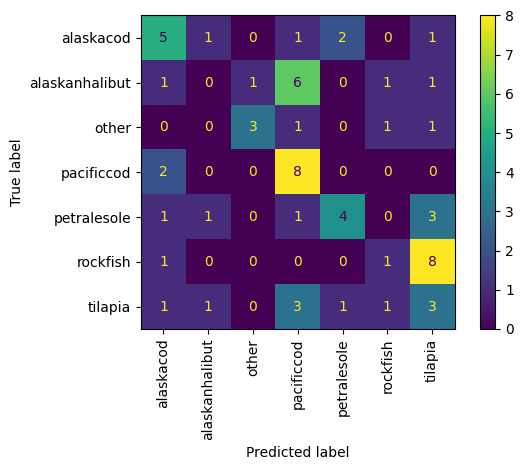

In [ ]:
cm = confusion_matrix(y_test, preds)  # a specific table layout that allows visualization of the performance of an algorithm
print(classification_report(y_test, preds, target_names=LABELS))  
disp = ConfusionMatrixDisplay(cm, display_labels=LABELS)  
disp.plot(xticks_rotation="vertical")  
plt.tight_layout()  
plt.show()  # Plot predictions, a good result should have a diagonal from top left to bottom right

Model accuracy defined by number of correct guesses vs incorrect guesses.

### Convert Trained Model to ONNX for Applications.

ONNX lets us package the trained python models optimized for runtime applications (e.g. web applications)

In [ ]:
from onnxconverter_common import FloatTensorType  
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost  
from skl2onnx import update_registered_converter, convert_sklearn  
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes  

In [ ]:
# Define options for the converter
opts = {
    "nocl": [True, False],  # Option for 'nocl': Indicates whether to use 'no class labels' in the output
    "zipmap": [True, False, "columns"],  # Option for 'zipmap': Determines how to output class probabilities, 
                                         # either as a dictionary (True), array (False), or as columns ("columns")
    "output_class_labels": [True, False]  # Option for 'output_class_labels': Indicates whether to output class labels
}

# Update or register a new converter for XGBClassifier with the ONNX converter
update_registered_converter(
    XGBClassifier,  # The scikit-learn classifier class that we want to convert to ONNX
    "XGBoostXGBClassifier",  # The name for the converter (as registered in ONNX)
    calculate_linear_classifier_output_shapes,  # Function to calculate the output shape of the converted model
    convert_xgboost,  # Function that defines how to convert the classifier to an ONNX model
    options=opts,  # Passing the options defined above to customize the conversion process
)

In [ ]:
# Convert the scikit-learn pipeline to ONNX format
model_onnx = convert_sklearn(
    pipe,  # The scikit-learn model or pipeline to convert, here 'pipe' refers to a predefined pipeline
    "fishazam-xgboost-classifier",  # Name for the ONNX model
    [("input", FloatTensorType([1, FLAT_IMG_SIZE]))],  # Define the model input name and type
    # 'input' is the name of the input tensor,
    # FloatTensorType([1, FLAT_IMG_SIZE]) specifies the data type and shape of the input tensor
    target_opset={"": 12, "ai.onnx.ml": 2},  # Specify the target ONNX operator set versions
    # "" refers to the default ONNX domain, with version 12
    # "ai.onnx.ml" refers to the machine learning domain, with version 2
    options={id(pipe): {"zipmap": False, "output_class_labels": False, "nocl": True}}
    # Set conversion options for the pipeline
    # "zipmap": False - Do not convert class probabilities to a dictionary format
    # "output_class_labels": False - Do not output the class labels
    # "nocl": True - Indicate that there are no class labels in the output
)

In [ ]:
with open("fishazam-xgboost-classifier.onnx", "wb") as f: # Save the trained model compilation.
    f.write(model_onnx.SerializeToString())  

#files.download("fishazam-xgboost-classifier.onnx") # (colab call to download the file to your machine)

### Your model file should be outputted to the same folder as this project on local machines, which can now be uploaded to ONNX Runtime applications.

Use [https://netron.app/](https://netron.app/) to evaluate the ONNX outputs. You need to format i/o into tensors with specific buffer types which are limited to:

- bool
- float16
- float32
- float64
- int16
- int32
- int8
- string
- uint16
- uint32
- uint64
- uint8